# Step 0. 필요한 라이브러리 import

In [1]:
import os
from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import tensorflow as tf
import pandas as pd

import re
import os
import io
import time
import random

import seaborn

import sentencepiece as spm

# Step 1. 데이터 정제 및 토큰화

1. 데이터 중복 제거

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 중복 제거
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f:
        kor = f.read().splitlines()
    with open(eng_path, "r") as f:
        eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    # 데이터프레임을 사용해 한-영 병렬 데이터로 변경
    data = pd.DataFrame()
    data['kor'] = kor
    data['eng'] = eng
    
    print("중복 제거 전 샘플 수: ", len(data))
    
    # 각 데이터 중복 제거
    data.drop_duplicates('kor', inplace=True)
    data.drop_duplicates('eng', inplace=True)
    
    cleaned_corpus = data.reset_index(drop=True)
    
    print("중복 제거 후 샘플 수: ", len(cleaned_corpus))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

중복 제거 전 샘플 수:  94123
중복 제거 후 샘플 수:  74849


2. 데이터 전처리 함수 정의

In [3]:
def preprocess_sentence(sentence):
    
    # 소문자로 치환, 앞뒤 공백 제거
    sentence = sentence.lower().strip()
    # 단어와 구두점(punctuation) 사이 뷴리
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 다중 공백 -> 단일 공백
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    
    return sentence

3. 데이터 전처리, tokenizer 생성

In [4]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = os.getenv('HOME')+f'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd05/korean-english-park.train.{lang}.temp'

    with open(temp_file, 'w') as f:
        for row in corpus:   
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
        
        '--pad_id={} --bos_id={} --eos_id={} --unk_id={} --input={} --model_prefix={}_spm --vocab_size={}'.format(
            pad_id, bos_id, eos_id, unk_id, temp_file, lang, vocab_size)    
    )
    #위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

    if (lang=="ko"):
        !ls -l ko_spm*
    else:
        !ls -l en_spm*
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{lang}_spm.model')
    
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

# 데이터 정제
eng_corpus = []
kor_corpus = []

for x in tqdm(cleaned_corpus['kor']):
    kor_corpus.append(preprocess_sentence(x))

for x in tqdm(cleaned_corpus['eng']):
    eng_corpus.append(preprocess_sentence(x))

# tokenizer 생성
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

  0%|          | 0/74849 [00:00<?, ?it/s]

  0%|          | 0/74849 [00:00<?, ?it/s]

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input=/aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd05/korean-english-park.train.ko.temp --model_prefix=ko_spm --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd05/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
 

-rw-r--r-- 1 root root 621612 Oct 23 06:45 ko_spm.model
-rw-r--r-- 1 root root 401909 Oct 23 06:45 ko_spm.vocab


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input=/aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd05/korean-english-park.train.en.temp --model_prefix=en_spm --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd05/korean-english-park.train.en.temp
  input_format: 
  model_prefix: en_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
 

-rw-r--r-- 1 root root 574328 Oct 23 06:46 en_spm.model
-rw-r--r-- 1 root root 354407 Oct 23 06:46 en_spm.vocab


True

4. 토큰화 및 토큰의 길이 50 이하인 데이터 선별

In [5]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    max_len=50
    
    ko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en = en_tokenizer.EncodeAsIds(eng_corpus[idx])

    if ((len(ko) <= max_len) & (len(en) <= max_len)):
        src_corpus.append(ko)
        tgt_corpus.append(en)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/74849 [00:00<?, ?it/s]

# Step 2. 모델 설계

Positional Encoding

In [6]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

Multi-Head Attention

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
      
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

Position-wise Feed-Forward Network

In [8]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

Encoder 레이어 구현

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

Decoder 레이어 구현

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

Encoder 정의

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

Decoder 정의

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

Transformer 정의

In [13]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

Masking 정의

In [14]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 3. 훈련

1. Transformer model 정의

In [15]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 1024
src_vocab_size = tgt_vocab_size = 20000
pos_len = 256

transformer = Transformer(
    n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len)

2. LearningRateSchedule 정의

In [16]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

3. Loss 정의

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. train_step 정의

In [18]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
    loss = 0
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

5. 학습 진행

In [19]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [20]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [21]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

학습 진행

In [22]:
BATCH_SIZE = 128
EPOCHS = 20

model_list =[]

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in tqdm(examples):
        translate(example, transformer, ko_tokenizer, en_tokenizer)
        
    model_list.append(transformer.get_weights())

  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: the  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first time .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect barack obama s campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s  ⁇ 5 , the city s  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: the needs , the needs , the needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the injured reports at least 1 .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president electy is a lot of president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is just buried in the city .
Input: 커피는 필요 없다.
Predicted translation: it s not just a few years .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the state of emergency .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s violence is in the city .
Input: 커피는 필요 없다.
Predicted translation: it s a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed in the death of the death .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents are going to be the city .
Input: 커피는 필요 없다.
Predicted translation: there are no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed in the deaths of the deaths .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is president barack obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: residents were in the city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for no need for no need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed in seven deaths .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected .
Input: 시민들은 도시 속에 산다.
Predicted translation: residents of city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for democracy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the dead , according to the seven ministry .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city .
Input: 커피는 필요 없다.
Predicted translation: there needs coffee need to need a single need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the death toll in the seven death toll .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect barack obama is
Input: 시민들은 도시 속에 산다.
Predicted translation: city .
Input: 커피는 필요 없다.
Predicted translation: there needs to be no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death tolls were killed in the death toll .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city in the city is city .
Input: 커피는 필요 없다.
Predicted translation: there needs to apply for a roll .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths happened seven in the city of the seven wounded .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is expected to president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets are in cities to the city .
Input: 커피는 필요 없다.
Predicted translation: it s no one need to coffee or the coffee does it needs to place .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven province fatalities .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to sometimes obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is in cities .
Input: 커피는 필요 없다.
Predicted translation: there needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths from the death toll in the city of the seven deaths .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to add obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is on cities .
Input: 커피는 필요 없다.
Predicted translation: there needs no one need to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths occurred .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president who s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is on the city s mountain .
Input: 커피는 필요 없다.
Predicted translation: there needs to apply for the need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the surpassing the seven death toll from the seven death toll .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is in the city of lakeland .
Input: 커피는 필요 없다.
Predicted translation: there needs no need for t improve .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the seven south africaned were seen .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of tuesday s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city fighters .
Input: 커피는 필요 없다.
Predicted translation: there needs no need for those needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths from the seven death toll was in the seven death .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president who obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is on the city s streets .
Input: 커피는 필요 없다.
Predicted translation: it needs to apply for something .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the blasts were killed .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president can turn off the president off .
Input: 시민들은 도시 속에 산다.
Predicted translation: city prompted the city of residents .
Input: 커피는 필요 없다.
Predicted translation: there needs no need for their need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the death toll happened .


  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president who s going to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city . then the city is on the city .
Input: 커피는 필요 없다.
Predicted translation: there s no need to apply for such a
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the range .


시각화

  0%|          | 0/4 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Encoder Layer 1


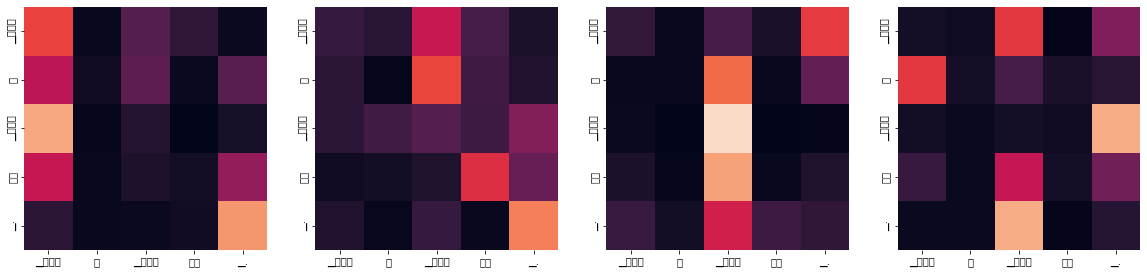

Encoder Layer 2


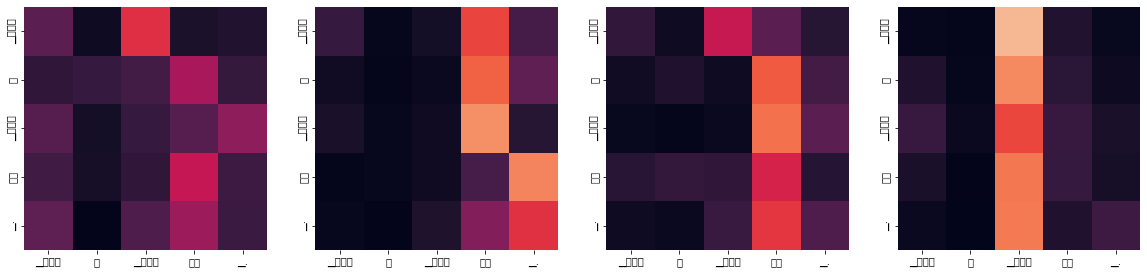

Decoder Self Layer 1


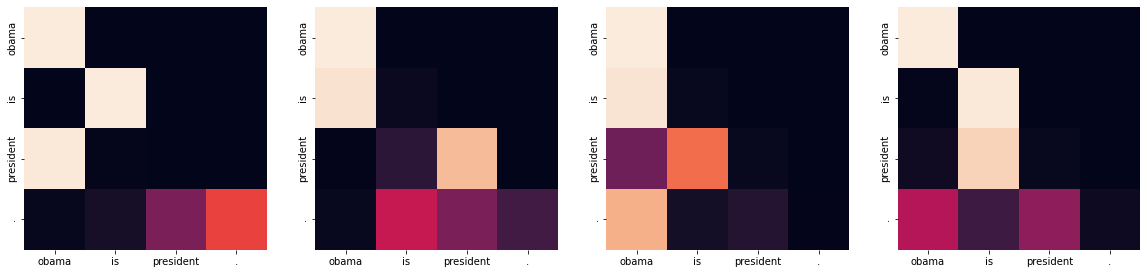

Decoder Src Layer 1


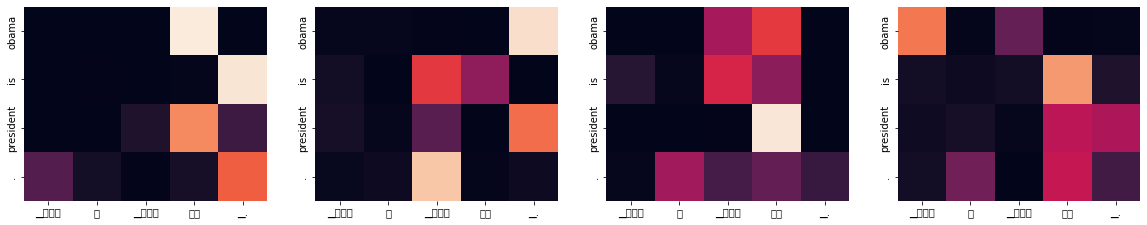

Decoder Self Layer 2


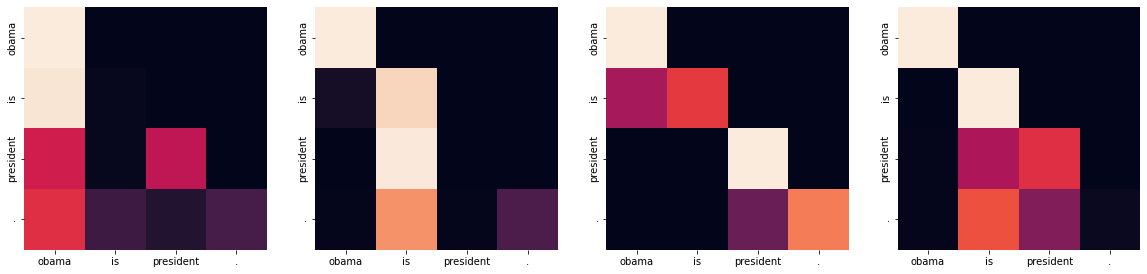

Decoder Src Layer 2


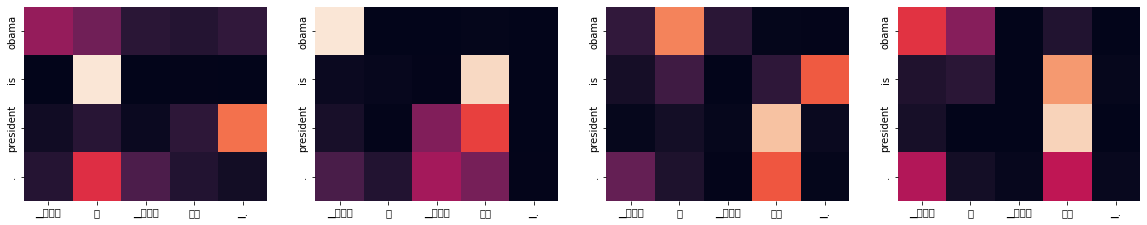

Input: 시민들은 도시 속에 산다.
Predicted translation: city residents are going to be the city .
Encoder Layer 1


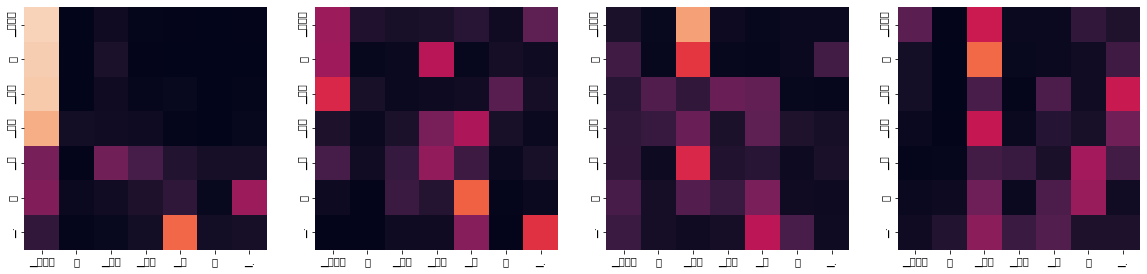

Encoder Layer 2


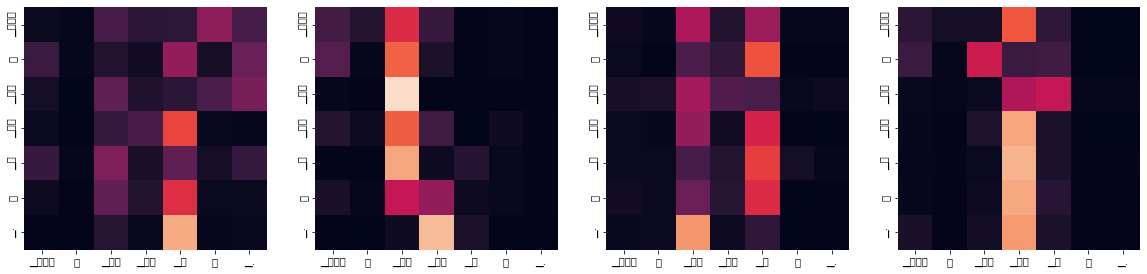

Decoder Self Layer 1


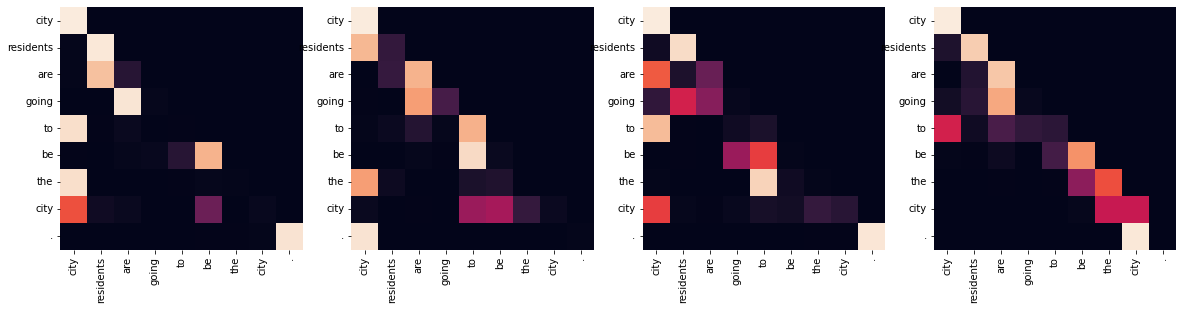

Decoder Src Layer 1


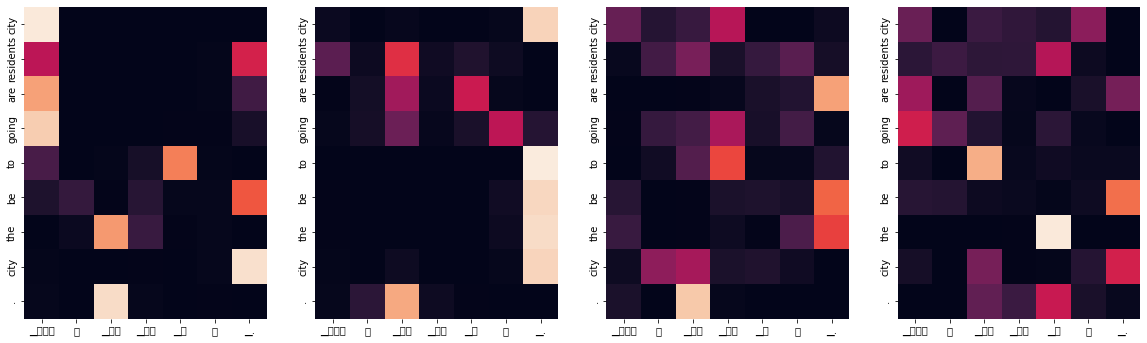

Decoder Self Layer 2


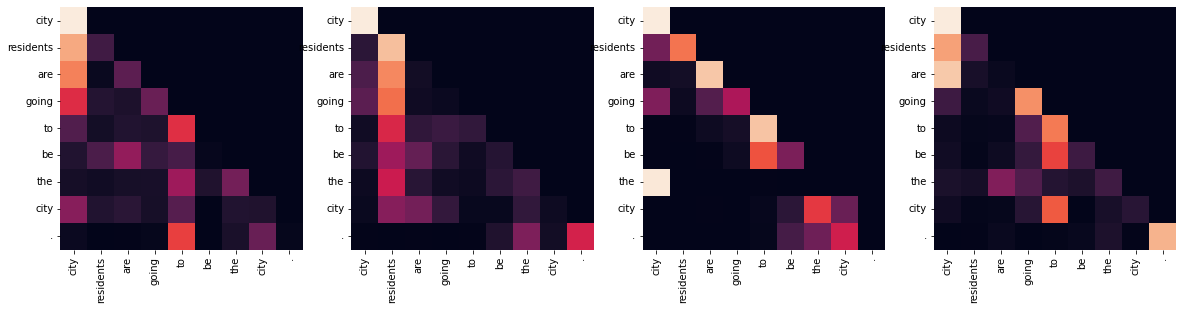

Decoder Src Layer 2


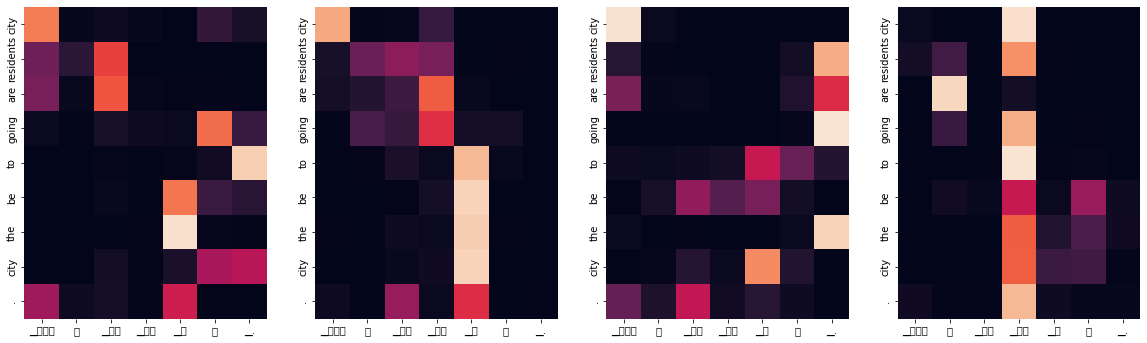

Input: 커피는 필요 없다.
Predicted translation: there are no need for coffee .
Encoder Layer 1


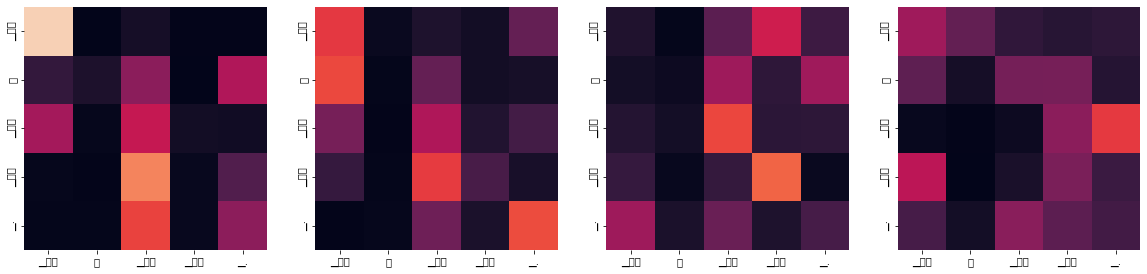

Encoder Layer 2


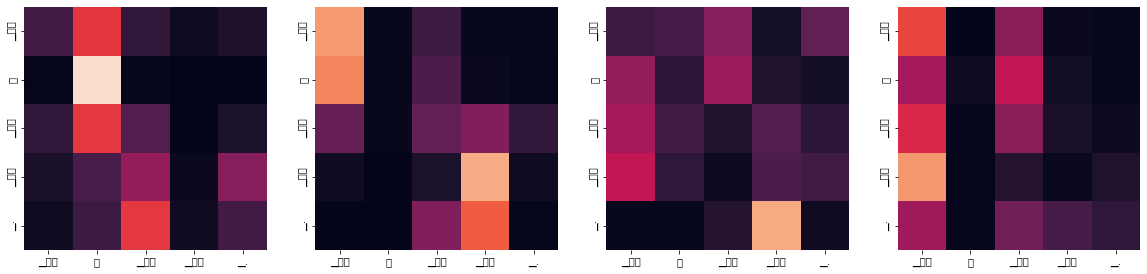

Decoder Self Layer 1


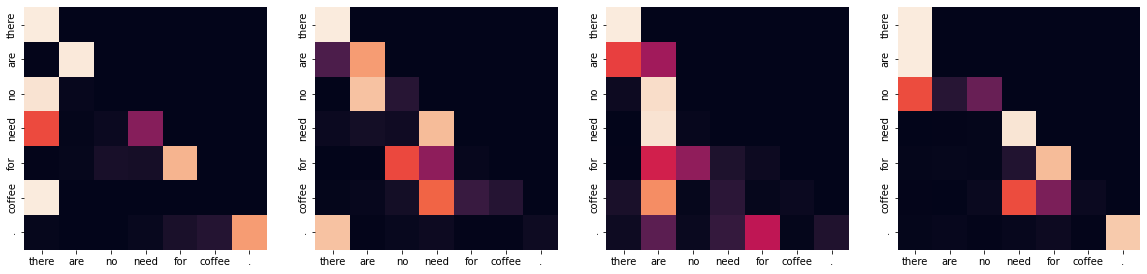

Decoder Src Layer 1


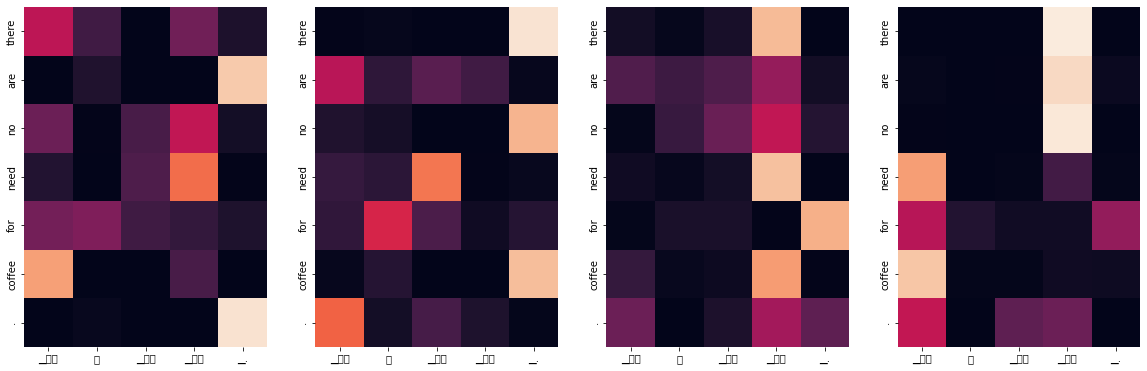

Decoder Self Layer 2


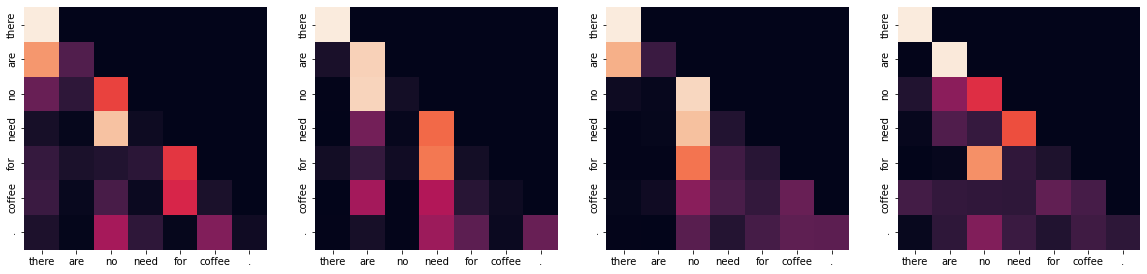

Decoder Src Layer 2


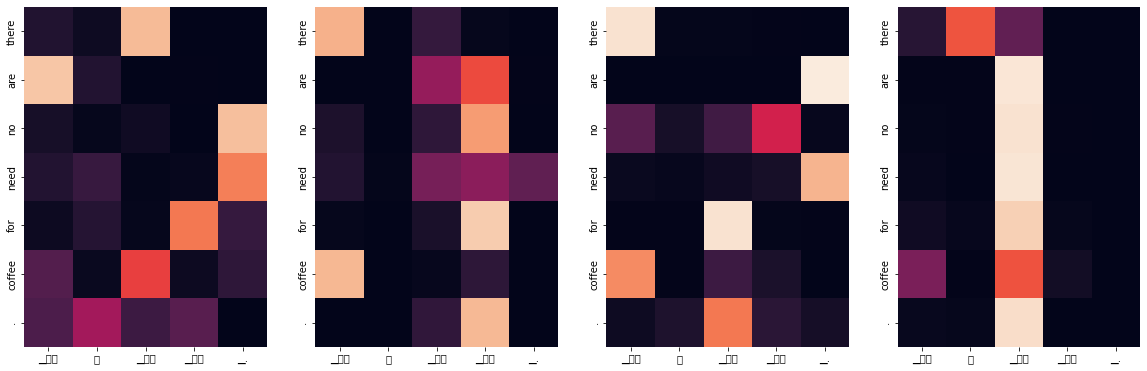

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed in the deaths of the deaths .
Encoder Layer 1


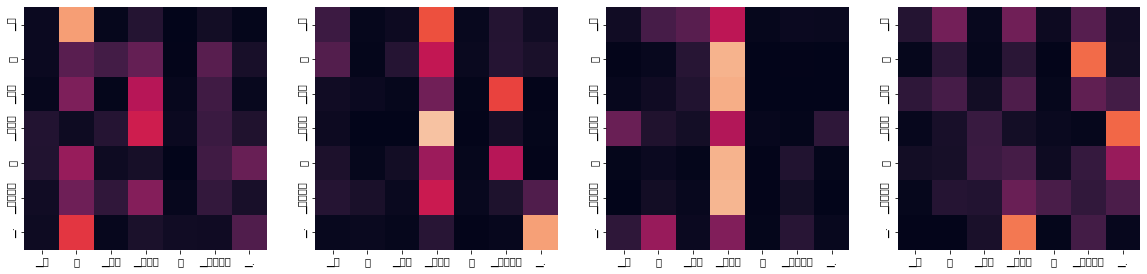

Encoder Layer 2


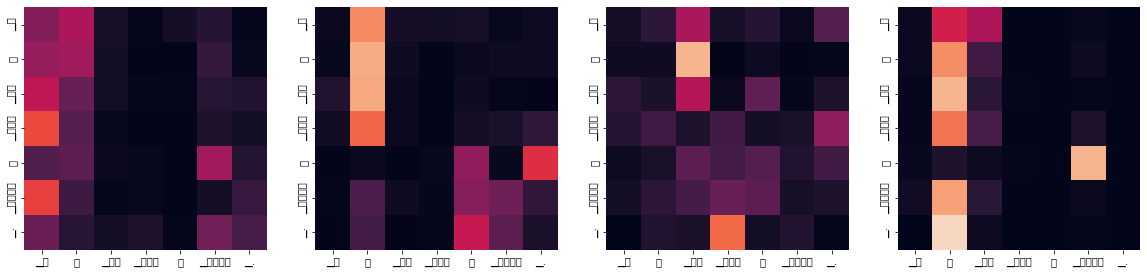

Decoder Self Layer 1


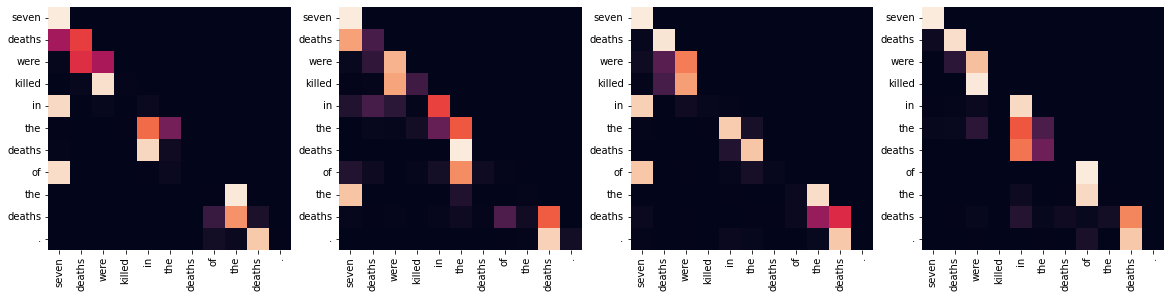

Decoder Src Layer 1


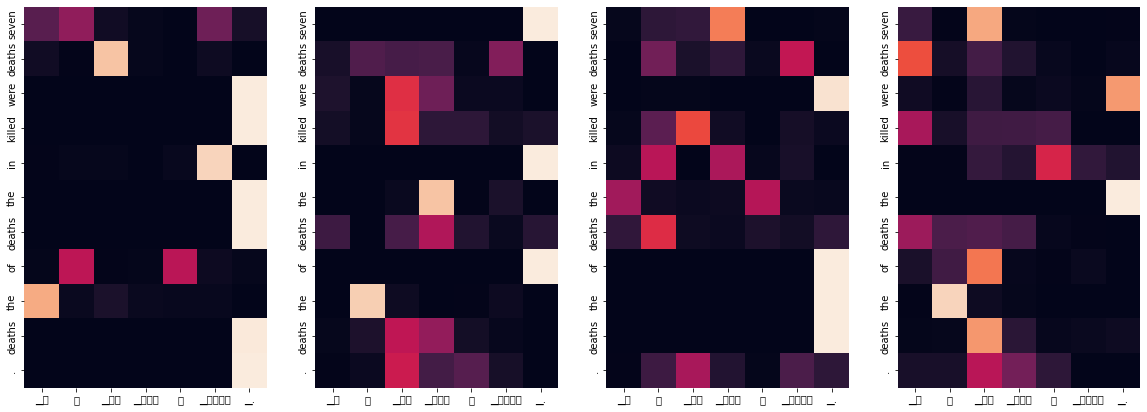

Decoder Self Layer 2


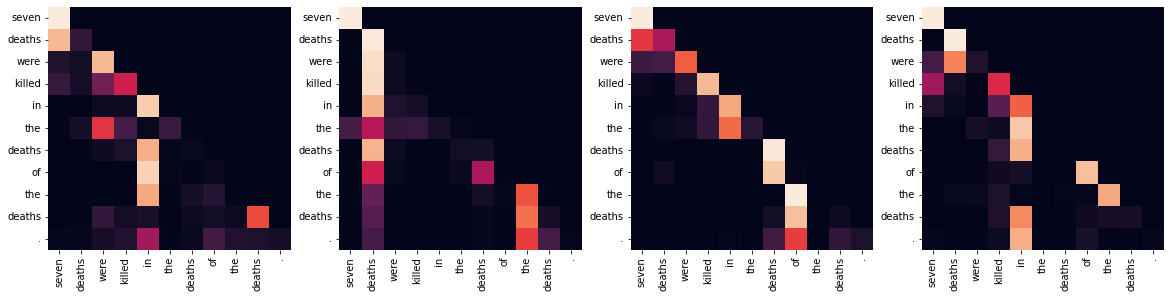

Decoder Src Layer 2


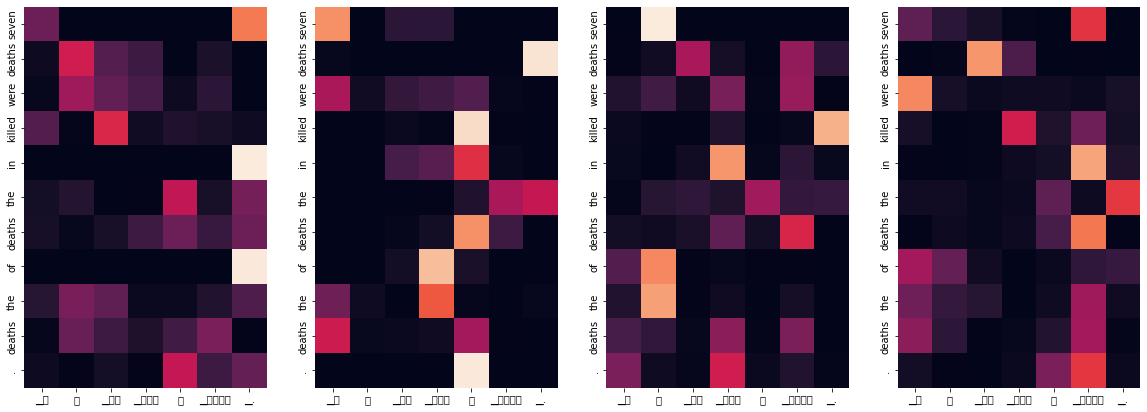

In [24]:
# 에포크 6번째 가중치로 시각화 index -> 5,
transformer.set_weights(model_list[5])

for example in tqdm(examples):
        translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# 회고

- 데이터 전처리, Sentencepiece를 활용한 토큰화는 복습하는 느낌으로 코딩
- 모델링은 노드에 나온대로 설계하면서 다시 한번 코드를 살펴보고 구조를 이해하는데 느낌으로 코딩
- 훈련 및 시각화 부분은 노드에 있던 그대로 셋팅 했음
    - 번역 결과가 만족스러울 때까지 한 8번 이상은 실행한듯
- 시각화 부분이 나름 만족스럽게 나왔음

이번 프로젝트를 통해 다시 한번 트랜스포머의 구조, 훈련 방식을 복습해 한발자국 더 트랜스포머에 다가간 것 같다!